In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import word2vecReader as godin_embedding
import pickle
from gensim.models import KeyedVectors
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [101]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [102]:
master_dict = load_data_from_json('dataset/master.json')

In [103]:
def extract_data_from_dict(master_dict):
    sentence = []
    aspect = []
    for key in master_dict.keys():
        for info in master_dict[key]['info']:
            sentence.append(eval(info['snippets'])[0])
            aspect.append(eval(info['aspects'])[0])
#         temp_aspect = []
#         for element in master_dict[key]['info']:
#             temp_aspect.append(eval(element['aspects']))
#         aspect.append(temp_aspect)
    return sentence,aspect

In [104]:
sentence,aspect = extract_data_from_dict(master_dict)

In [105]:
len(sentence),len(aspect)

(1171, 1171)

In [106]:
aspect_level1= []
aspect_level2=[]
for asp in aspect:
    try:
        aspect_level1.append(asp.split('/')[0])
        aspect_level2.append(asp.split('/')[1])
    except:
        print(asp)
# aspect_f

In [107]:
n_label_level_1 = len(set(aspect_level1))
n_label_level_2 = len(set(aspect_level2))
n_label_level_1,n_label_level_2

(4, 27)

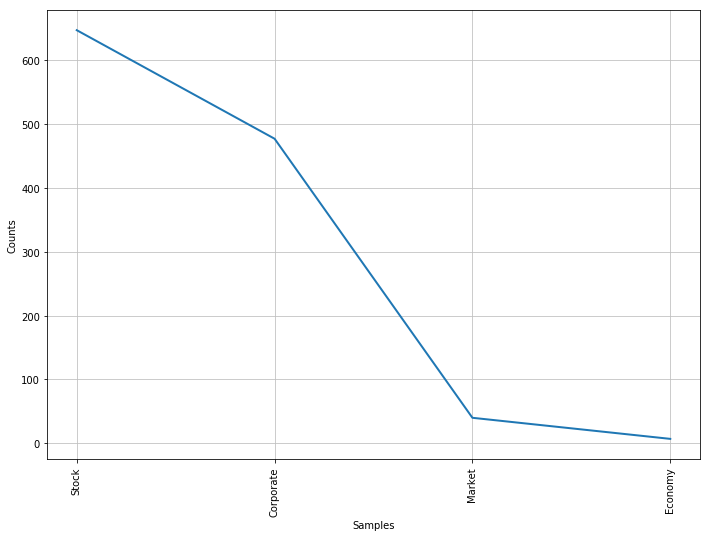

FreqDist({'Stock': 647, 'Corporate': 477, 'Market': 40, 'Economy': 7})


In [108]:
level1_freq = FreqDist(aspect_level1)
level1_freq.plot()
level1_freq.pprint()

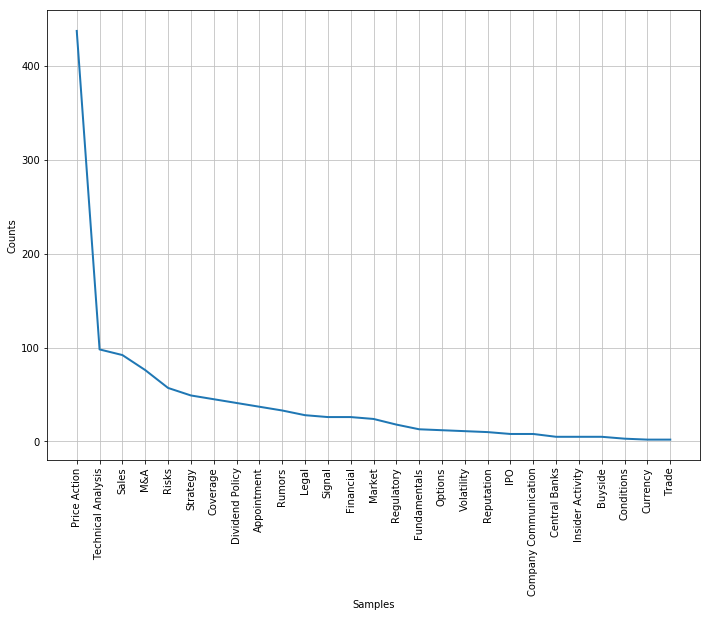

FreqDist({'Price Action': 437, 'Technical Analysis': 98, 'Sales': 92, 'M&A': 76, 'Risks': 57, 'Strategy': 49, 'Coverage': 45, 'Dividend Policy': 41, 'Appointment': 37, 'Rumors': 33, 'Legal': 28, 'Signal': 26, 'Financial': 26, 'Market': 24, 'Regulatory': 18, 'Fundamentals': 13, 'Options': 12, 'Volatility': 11, 'Reputation': 10, 'IPO': 8, 'Company Communication': 8, 'Central Banks': 5, 'Insider Activity': 5, 'Buyside': 5, 'Conditions': 3, 'Currency': 2, 'Trade': 2})


In [109]:
level2_freq = FreqDist(aspect_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [110]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [111]:
L2_L1_pair = get_level_pairs(aspect_level1,aspect_level2)
L1_L2_pair = get_level_pairs(aspect_level2,aspect_level1)

In [112]:
L1_L2_pair

{'Corporate': ['Reputation',
  'Company Communication',
  'Appointment',
  'Financial',
  'Regulatory',
  'Sales',
  'M&A',
  'Legal',
  'Dividend Policy',
  'Risks',
  'Rumors',
  'Strategy',
  'Technical Analysis'],
 'Economy': ['Trade', 'Central Banks'],
 'Market': ['Currency', 'Conditions', 'Market', 'Volatility'],
 'Stock': ['Options',
  'IPO',
  'Signal',
  'Coverage',
  'Fundamentals',
  'Insider Activity',
  'Price Action',
  'Buyside',
  'Technical Analysis']}

In [113]:
L2_L1_pair

{'Appointment': ['Corporate'],
 'Buyside': ['Stock'],
 'Central Banks': ['Economy'],
 'Company Communication': ['Corporate'],
 'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Currency': ['Market'],
 'Dividend Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'IPO': ['Stock'],
 'Insider Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Options': ['Stock'],
 'Price Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Corporate', 'Stock'],
 'Trade': ['Economy'],
 'Volatility': ['Market']}

In [114]:
with open('models/l2_l1_map.json','w') as f:
    json.dump(L2_L1_pair,f,indent=4)

In [115]:
def remove_punctuation(s):
    list_punctuation = list(punctuation.replace('$',''))
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [116]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens


In [117]:
sentenceX = [clean_sentence(x) for x in sentence]

In [118]:
Level_1Y = aspect_level1
Level_2Y = aspect_level2

In [119]:
lengths = [len(s.split()) for s in sentenceX]

max len =  15


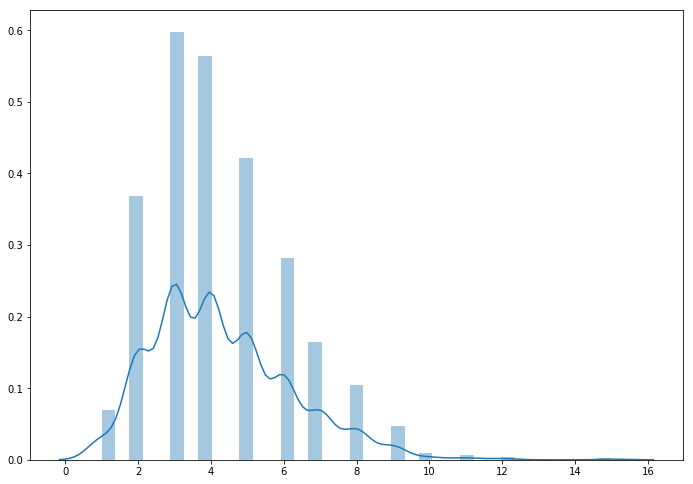

In [120]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [121]:
max_length  = max(lengths)

In [122]:
tranLines = sentenceX
trainLabels = aspect_level2

In [123]:
no_of_classes = n_label_level_2
no_of_classes

27

In [124]:
trainX, testX, trainY, testY = train_test_split(tranLines, trainLabels, test_size=0.1)

In [125]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

1053 1053
118 118


In [126]:
backup_trainX = trainX
backup_trainY = trainY
backup_testX = testX

In [127]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [128]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [129]:

tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape)

Max document length: 15
Vocabulary size: 1979
(1053, 15)


In [130]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY+testY)
    temp1 = le.transform(trainY)
#     temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),le.classes_

In [131]:
trainY,lable_encoding = convert_lables(trainY,testY)

In [132]:
with open('models/label_encoding.json','w') as f:
    json.dump({'lables_index':list(lable_encoding)},f)

In [55]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [56]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embeddings_index_glove = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
embedding_matrix_glove = get_GloVe_embedding_matrix(embeddings_index_glove)

In [57]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
#                 sentence = sentence.encode('UTF-8')
#                 print(sentence)
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [58]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [ ]:
#need to fix this
fast_text_model = load_fast_text_model(sentence)
embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)#loading godin word embedding

In [59]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [60]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [ ]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

In [133]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [134]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [135]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [136]:
def define_model(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,free_em_dim):
    model = Sequential()
    
    if em == 'free':
        model.add(Embedding(vocab_size, free_em_dim))
    else:
        model.add(Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=dropout)))
    for i in range(n_hidden_layer):
        model.add(Dense(int((2*lstm_out+no_of_classes)/2),activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    print(model.summary())
    return model

In [137]:
model = define_model(learning_rate=0.0006,
                         dropout=0.25,
                         lstm_out=600,
                         n_hidden_layer=1,
                         em='embedding_matrix_word2vec',
                         em_trainable_flag=True,
                         free_em_dim=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 300)           593700    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1200)              4324800   
_________________________________________________________________
dense_3 (Dense)              (None, 613)               736213    
_________________________________________________________________
dense_4 (Dense)              (None, 27)                16578     
Total params: 5,671,291
Trainable params: 5,671,291
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
history_object = model.fit(trainX, trainY, epochs=70,batch_size=64)

Epoch 1/70
1053/1053 [==============================] - 15s 14ms/step - loss: 2.7128 - acc: 0.3523
Epoch 2/70
1053/1053 [==============================] - 14s 13ms/step - loss: 1.9801 - acc: 0.4786
Epoch 3/70
1053/1053 [==============================] - 14s 13ms/step - loss: 1.4481 - acc: 0.6002
Epoch 4/70
1053/1053 [==============================] - 14s 14ms/step - loss: 1.0178 - acc: 0.7341
Epoch 5/70
1053/1053 [==============================] - 14s 13ms/step - loss: 0.6841 - acc: 0.8129
Epoch 6/70
1053/1053 [==============================] - 13s 13ms/step - loss: 0.4716 - acc: 0.8737
Epoch 7/70
1053/1053 [==============================] - 13s 13ms/step - loss: 0.3686 - acc: 0.8908
Epoch 8/70
1053/1053 [==============================] - 13s 13ms/step - loss: 0.2447 - acc: 0.9231
Epoch 9/70
1053/1053 [==============================] - 13s 13ms/step - loss: 0.1831 - acc: 0.9516
Epoch 10/70
1053/1053 [==============================] - 13s 13ms/step - loss: 0.1240 - acc: 0.9639
Epoch 11/

In [139]:
model.save('models/bestAspect_snippt_master.h5')

In [140]:
pred = model.predict(testX)

In [141]:
def get_class_from_pred(pred):
    return [lable_encoding[x.argmax()] for x in pred]

In [142]:
pred_class = get_class_from_pred(pred)

In [143]:
#get metric scores
def print_metric(yacc,ypred,avg_type=None):
    print('---------------------avg type = {0}---------------------------------------------'.format(avg_type))
    print('F1 score == ', f1_score(yacc,ypred,average=avg_type))
    print('precision score == ', precision_score(yacc,ypred,average=avg_type))
    print('recall score == ', recall_score(yacc,ypred,average=avg_type))
    print('accuracy score == ', accuracy_score(yacc,ypred))

In [145]:
print_metric(testY,pred_class)
print_metric(testY,pred_class,'micro')
print_metric(testY,pred_class,'macro')
print_metric(testY,pred_class,'weighted')

---------------------avg type = None---------------------------------------------
F1 score ==  [1.         0.         0.         0.         0.85714286 0.92307692
 0.4        0.         0.         1.         0.84210526 0.25
 1.         0.74157303 1.         0.         0.75       1.
 0.8        0.88888889 0.8        0.53846154 0.        ]
precision score ==  [1.         0.         0.         0.         1.         0.85714286
 0.5        0.         0.         1.         0.88888889 0.14285714
 1.         0.7173913  1.         0.         1.         1.
 0.72727273 0.8        1.         0.53846154 0.        ]
recall score ==  [1.         0.         0.         0.         0.75       1.
 0.33333333 0.         0.         1.         0.8        1.
 1.         0.76744186 1.         0.         0.6        1.
 0.88888889 1.         0.66666667 0.53846154 0.        ]
accuracy score ==  0.7288135593220338
---------------------avg type = micro---------------------------------------------
F1 score ==  0.7288

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## test on second test data now

In [86]:
test_dict = load_data_from_json('dataset/master_test.json')

In [87]:
sentence_test,aspect_test = extract_data_from_dict(test_dict)

In [90]:
aspect_level1_test= []
aspect_level2_test =[]
for asp in aspect_test:
    try:
        aspect_level1_test.append(asp.split('/')[0])
        aspect_level2_test.append(asp.split('/')[1])
    except:
        print(asp)

In [91]:
aspect_level2_test

['Price Action',
 'Financial',
 'Price Action',
 'Price Action',
 'Sales',
 'Risks',
 'Sales',
 'Coverage',
 'Price Action',
 'Risks',
 'Options',
 'Risks',
 'Market',
 'Signal',
 'Price Action',
 'Price Action',
 'Technical Analysis',
 'Price Action',
 'Technical Analysis',
 'Price Action',
 'Rumors',
 'Risks',
 'Dividend Policy',
 'M&A',
 'Technical Analysis',
 'Price Action',
 'Price Action',
 'Price Action',
 'Price Action',
 'Risks',
 'Price Action',
 'M&A',
 'Price Action',
 'Price Action',
 'Coverage',
 'Price Action',
 'Risks',
 'Price Action',
 'Risks',
 'Strategy',
 'Risks',
 'Technical Analysis',
 'Strategy',
 'Price Action',
 'Strategy',
 'Price Action',
 'M&A',
 'Risks',
 'Price Action',
 'Coverage',
 'Technical Analysis',
 'Signal',
 'Price Action',
 'Risks',
 'Price Action',
 'Coverage',
 'Coverage',
 'Coverage',
 'Risks',
 'Price Action',
 'Price Action',
 'Coverage',
 'Signal',
 'Financial',
 'Price Action',
 'Price Action',
 'Technical Analysis',
 'Price Action',
 'Ri

In [92]:
sentence_test = [clean_sentence(x) for x in sentence_test]

In [94]:
backup_sentence_test = sentence_test

In [95]:
sentence_test = encode_text(tokenizer, sentence_test, max_length)

In [96]:
pred = model.predict(sentence_test)

In [97]:
pred_class = get_class_from_pred(pred)

In [98]:
print_metric(aspect_level2_test,pred_class)
print_metric(aspect_level2_test,pred_class,'micro')
print_metric(aspect_level2_test,pred_class,'macro')
print_metric(aspect_level2_test,pred_class,'weighted')

---------------------avg type = None---------------------------------------------
F1 score ==  [0.90909091 1.         0.6        0.66666667 0.         0.
 0.72897196 0.         0.92857143 0.         0.5        0.85714286
 0.66666667 0.31578947 0.        ]
precision score ==  [1.         1.         0.5        1.         0.         0.
 0.66101695 0.         1.         0.         1.         1.
 1.         0.33333333 0.        ]
recall score ==  [0.83333333 1.         0.75       0.5        0.         0.
 0.8125     0.         0.86666667 0.         0.33333333 0.75
 0.5        0.3        0.        ]
accuracy score ==  0.7117117117117117
---------------------avg type = micro---------------------------------------------
F1 score ==  0.7117117117117117
precision score ==  0.7117117117117117
recall score ==  0.7117117117117117
accuracy score ==  0.7117117117117117
---------------------avg type = macro---------------------------------------------
F1 score ==  0.47819333096263744
precision score =

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
